# EDS Case Study

Explore changes in political views

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import decorate

## Loading and validation


In [2]:
gss = pd.read_hdf('eds.gss.hdf5', 'gss')
gss.shape

(64814, 105)

### Validating `polviews`

`polviews` contains responses to the [following question](https://gssdataexplorer.norc.org/projects/52787/variables/178/vshow)

> We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

`values` takes a variable column and returns a series of values and their frequencies.

In [3]:
def values(series):
    return series.value_counts().sort_index()

In [4]:
values(gss['polviews'])

1.0     1637
2.0     6398
3.0     6865
4.0    21521
5.0     8953
6.0     8149
7.0     1833
Name: polviews, dtype: int64

In [5]:
gss74 = gss['year']==1974
gss74.sum()

1484

In [6]:
polviews74 = gss.loc[gss74, 'polviews']
values(polviews74)

1.0     21
2.0    191
3.0    201
4.0    543
5.0    252
6.0    169
7.0     34
Name: polviews, dtype: int64

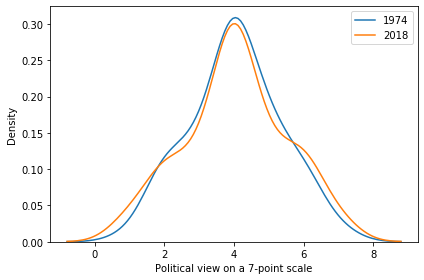

In [7]:
gss18 = gss['year'] == 2018
polviews18 = gss.loc[gss18, 'polviews']

sns.kdeplot(polviews74.dropna(), bw=0.6, label='1974')
sns.kdeplot(polviews18.dropna(), bw=0.6, label='2018')

decorate(xlabel='Political view on a 7-point scale',
         ylabel='Density')

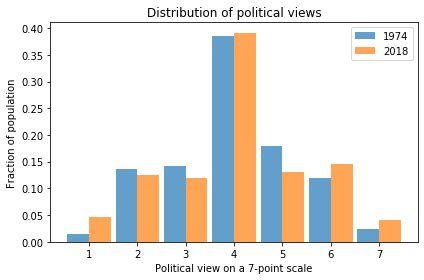

In [8]:
from empiricaldist import Pmf

Pmf.from_seq(polviews74).bar(label='1974', width=-0.45, align='edge', alpha=0.7)
Pmf.from_seq(polviews18).bar(label='2018', width=0.45, align='edge', alpha=0.7)

decorate(xlabel='Political view on a 7-point scale',
         ylabel='Fraction of population',
         title='Distribution of political views')

In [9]:
polviews74 = gss.loc[gss74, 'polviews']
values(polviews74)

1.0     21
2.0    191
3.0    201
4.0    543
5.0    252
6.0    169
7.0     34
Name: polviews, dtype: int64

In [10]:
polviews74 = gss.loc[gss74, 'polviews']
values(polviews74)

1.0     21
2.0    191
3.0    201
4.0    543
5.0    252
6.0    169
7.0     34
Name: polviews, dtype: int64

In [11]:
by_year = gss.groupby('year')
by_year

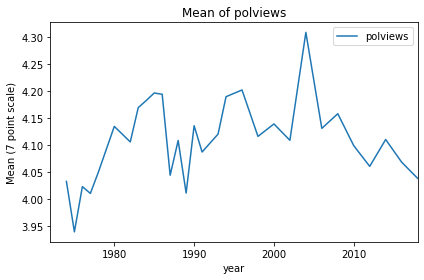

In [12]:
series = by_year['polviews'].mean()
series.plot(label='polviews')
decorate(ylabel='Mean (7 point scale)',
         title='Mean of polviews')

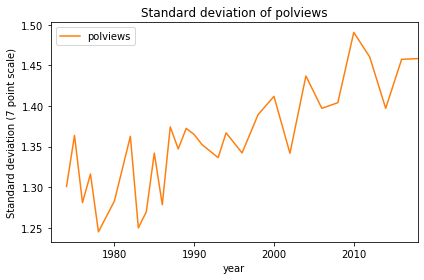

In [13]:
series = by_year['polviews'].std()
series.plot(color='C1', label='polviews')
decorate(ylabel='Standard deviation (7 point scale)',
         title='Standard deviation of polviews')

### Local regression

In [14]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    endog = series.values
    exog = series.index.values

    smooth = lowess(endog, exog)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index) 

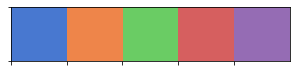

In [15]:
palette = sns.color_palette('muted', 5)
sns.palplot(palette)

In [16]:
colors = dict(Conservative=palette[3], 
              Moderate=palette[4], 
              Liberal=palette[0])

In [17]:
def plot_series_lowess(series, color):
    series.plot(lw=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)

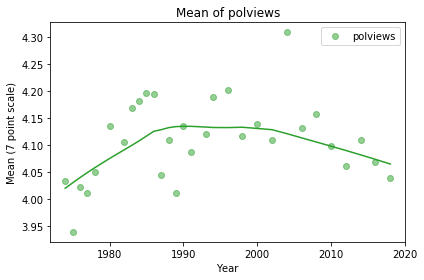

In [18]:
series = by_year['polviews'].mean()
plot_series_lowess(series, 'C2')
decorate(ylabel='Mean (7 point scale)',
         title='Mean of polviews',
         xlabel='Year',
         xlim=[1972, 2020])

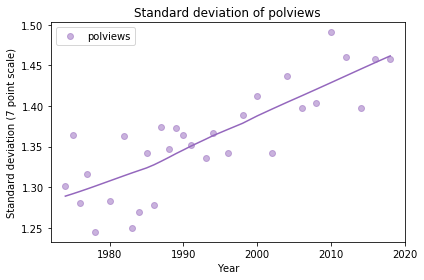

In [19]:
series = by_year['polviews'].std()
plot_series_lowess(series, color='C4')
decorate(ylabel='Standard deviation (7 point scale)',
         title='Standard deviation of polviews',
         xlabel='Year',
         xlim=[1972, 2020])

### 3-point scale

To make it easier to visualize groups, I'm going to lump the 7-point scale into a 3-point scale.

With this scale, there are roughly the same number of people in each group.

In [20]:
# replace 7 point scale with 3 point scale
d = {1:'Liberal', 2:'Liberal', 3:'Liberal', 
     4:'Moderate', 
     5:'Conservative', 6:'Conservative', 7:'Conservative'}
gss['polviews3'] = gss.polviews.replace(d)
values(gss['polviews3'])

Conservative    18935
Liberal         14900
Moderate        21521
Name: polviews3, dtype: int64

In [21]:
def count_by_year(gss, varname):
    """
    """
    grouped = gss.groupby([varname, 'year'])
    count = grouped[varname].count().unstack(level=0)
    
    # note: the following is not ideal, because it does not
    # distinguish 0 from NA
    count = count.replace(0, np.nan).dropna()
    return count

polviews3_count = count_by_year(gss, 'polviews3')
polviews3_count.head()

polviews3,Conservative,Liberal,Moderate
year,,,
1974,455,413,543
1975,412,424,565
1976,436,389,571
1977,444,426,579
1978,454,396,584


In [22]:
total = polviews3_count.sum(axis=1)
total.head()

year
1974    1411
1975    1401
1976    1396
1977    1449
1978    1434
dtype: int64

In [23]:
polviews3_prop = polviews3_count.div(total, axis=0)
polviews3_prop.head()

polviews3,Conservative,Liberal,Moderate
year,,,
1974,0.322466,0.292700,0.384833
1975,0.294076,0.302641,0.403283
1976,0.312321,0.278653,0.409026
1977,0.306418,0.293996,0.399586
1978,0.316597,0.276151,0.407252


In [24]:
def plot_columns_lowess(df, columns, colors):
    for col in columns:
        series = df[col]
        plot_series_lowess(series, colors[col])

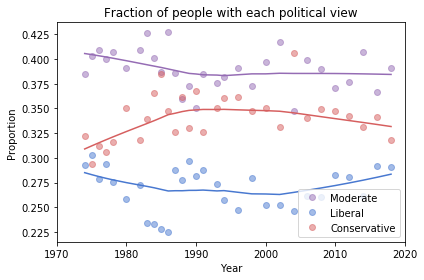

In [25]:
columns = ['Moderate', 'Liberal', 'Conservative']
plot_columns_lowess(polviews3_prop, columns, colors)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with each political view',
         xlim=[1970, 2020])